## 두피 및 머리카락 면적 기능
1. 이미지 로드 후 LAB 변환
2. KMeans를 적용하여 머리카락과 두피 분리
3. 각 비율 계산 및 결과

In [ ]:
import zipfile
import os
# 폴더가 존재하지 않으면 경로에 압축해제
if not os.path.exists('clust_img'):
    path = '/content/drive/MyDrive/dataset/clus_img.zip' # 폴더 경로
    f_zip = zipfile.ZipFile(path)
    f_zip.extractall('clust_img')
    f_zip.close()

필요한 라이브러리 임포트

In [ ]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### K-Means 기반 두피 분석 시각화


- LAB 색공간 변환 : K-Means의 정확도를 높이기 위해 LAB 색공간에서 클러스터링 수행
- 2개의 클러스터(머리카락 = 0, 두피 = 1)로 분류
- 밝기 기준 자동 조절 : 두피 & 머리카락 자동 식별
- 머리카락 및 두피 비율 분석 : 분류된 픽셀의 비율을 계산
- 원본과 분할된 이미지를 비교하여 출력


이미지 이름 : 1071_A2LEBJJDE00173R_1604931182344_3_TH.jpg
머리카락 비율: 7.43% (22815개)
두피 비율: 92.57% (284385개)

이미지 이름 : 0844_A2LEBJJDE00067A_1605059327468_4_LH.jpg
머리카락 비율: 15.97% (49075개)
두피 비율: 84.03% (258125개)

이미지 이름 : 2013_A2LEBJJDE00141O_1603008166327_5_RH.jpg
머리카락 비율: 18.03% (55373개)
두피 비율: 81.97% (251827개)

이미지 이름 : 0703_A2LEBJJDE000774_1604020630032_4_LH.jpg
머리카락 비율: 7.65% (23490개)
두피 비율: 92.35% (283710개)

이미지 이름 : 1940_A2LEBJJDE000307_1602650678501_5_RH.jpg
머리카락 비율: 7.71% (23681개)
두피 비율: 92.29% (283519개)

이미지 이름 : 1719_A2LEBJJDE00138G_1602814642459_5_RH.jpg
머리카락 비율: 51.86% (159324개)
두피 비율: 48.14% (147876개)

이미지 이름 : 1195_A2LEBJJDE00197M_1604568129545_2_TH.jpg
머리카락 비율: 11.02% (33856개)
두피 비율: 88.98% (273344개)

이미지 이름 : 5030_A2LEBJJDE00186Z_1606294570567_4_LH.jpg
머리카락 비율: 19.77% (60744개)
두피 비율: 80.23% (246456개)

이미지 이름 : 1142_A2LEBJJDE00024K_1605944053798_3_TH.jpg
머리카락 비율: 29.15% (89547개)
두피 비율: 70.85% (217653개)



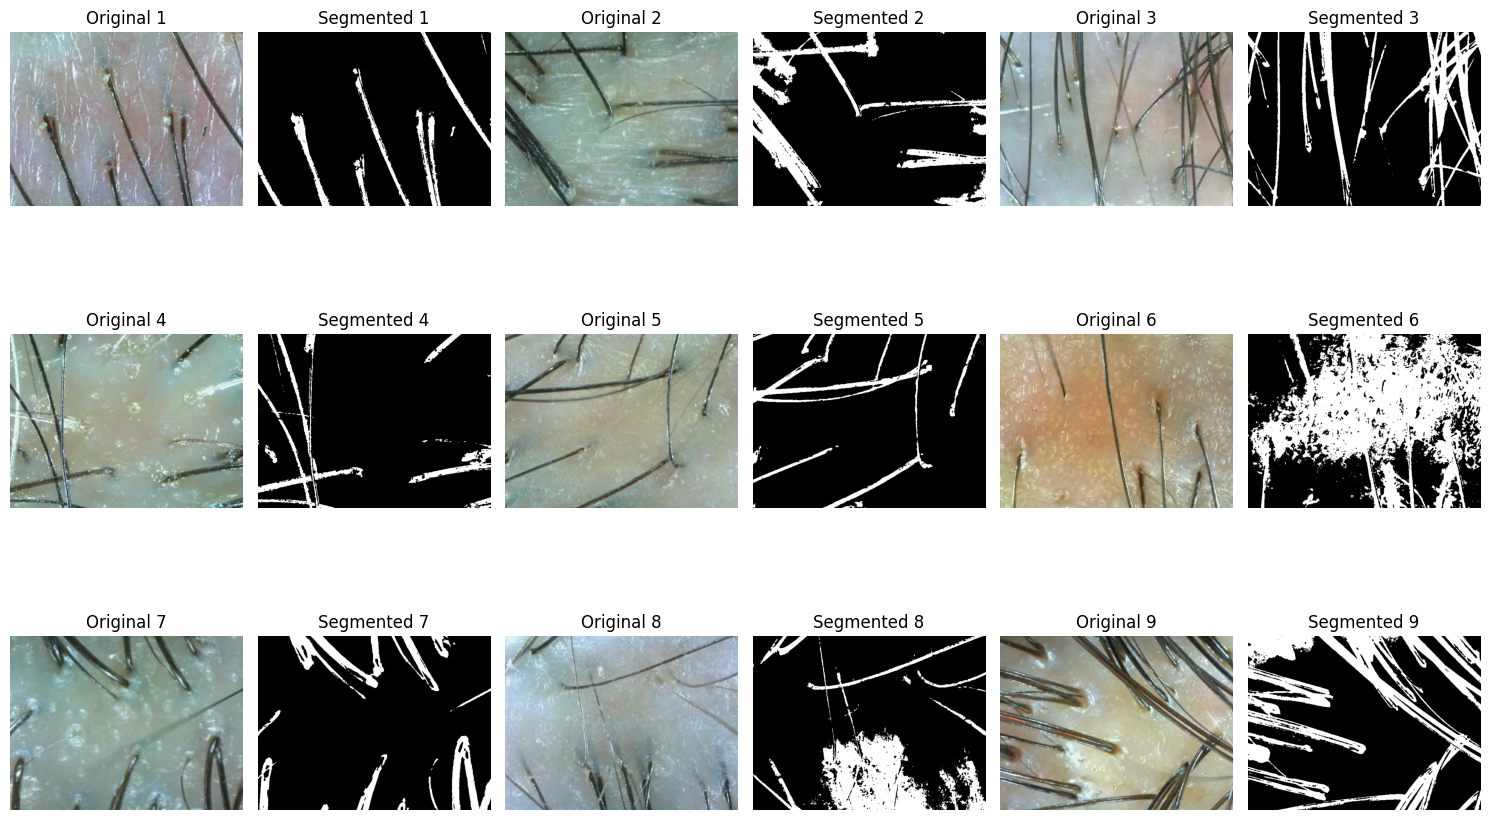

In [ ]:
image_folder = "/content/clust_img/clustering_img"
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

# 최대 9개의 이미지만 샘플링
num_samples = min(len(image_files), 9)
sample_images = image_files[:num_samples]

# 서브플롯 설정 (3x6 = 9개 이미지 * 원본 & 세그먼트)
fig, axes = plt.subplots(3, 6, figsize=(15, 10))

valid_count = 0  # 정상적으로 로드된 이미지 개수

for img_path in sample_images:
    image = cv2.imread(img_path)

    # 이미지 로드 실패 시 건너뛰기
    if image is None:
        continue

    # 원본 이미지를 RGB로 변환 (OpenCV는 기본적으로 BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # LAB 색공간 변환
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # 픽셀을 2D 배열로 변환
    pixels = image_lab.reshape((-1, 3))

    # K-Means 클러스터링 (머리카락=0, 두피=1로 클러스터 2개 설정)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)

    # 밝기 기준으로 두피(1), 머리카락(0)
    label_0_mean = np.mean(pixels[labels == 0])
    label_1_mean = np.mean(pixels[labels == 1])

    if label_0_mean > label_1_mean:
        labels = np.where(labels == 0, 1, 0)  # 두피 = 1, 머리카락 = 0으로 변환
    else:
        labels = np.where(labels == 1, 1, 0)  # 반대 상황 처리

    # 원본 형태로 복원
    segmented_image = labels.reshape(image.shape[:2])

    # 머리카락과 두피 면적(픽셀 수) 계산
    hair_pixels = np.sum(segmented_image == 0)
    scalp_pixels = np.sum(segmented_image == 1)
    total_pixels = hair_pixels + scalp_pixels

    hair_ratio = hair_pixels / total_pixels * 100  # 머리카락 비율 (%)
    scalp_ratio = scalp_pixels / total_pixels * 100  # 두피 비율 (%)

    # 머리카락 & 두피 비율 출력
    print(f"이미지 이름 : {os.path.basename(img_path)}")
    print(f"머리카락 비율: {hair_ratio:.2f}% ({hair_pixels}개)")
    print(f"두피 비율: {scalp_ratio:.2f}% ({scalp_pixels}개)\n")

    # 원본 이미지 출력
    ax1 = axes[valid_count // 3, (valid_count % 3) * 2]
    ax1.imshow(image_rgb)
    ax1.set_title(f"Original {valid_count+1}")
    ax1.axis("off")

    # K-Means 결과 출력
    ax2 = axes[valid_count // 3, (valid_count % 3) * 2 + 1]
    ax2.imshow(segmented_image, cmap='binary')
    ax2.set_title(f"Segmented {valid_count+1}")
    ax2.axis("off")

    valid_count += 1

    if valid_count >= 9:
        break

plt.tight_layout()
plt.show()


#결과
- 이미지마다 두피 색상이 달라 다수의 데이터 통합이 어려워 각 이미지 내에서 K-Means 학습 진행
- 테스트 재사용은 어려우나 단일 이미지 실시간 처리에 적합한 미시적 접근 방식 사용

- K-Means 클러스터링을 적용하여 두피와 머리카락을 일정 수준 이상으로 분류 가능
- 밝기를 기준으로 클러스터를 자동 조정하는 방법이 유효함

#한계점
- 비지도 학습 기반으로 동작하여 일부 이미지에서는 두피와 머리카락의 분리가 정확하지 않은 경우도 존재
- 클러스터 개수를 고정한 방식으로 더 정교한 분류를 위해 다른 모델 적용 고려(FAST-CNN, U-NET 등)